In this notebook, we will look at a few different ways of visualizing the chemical space covered by a set of molecules. We will cover principal component anlaysis (PCA) and t-distributed stochastic neighbor embedding (t-sne)

We will start by importing a the necessary Python libraries

In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

We set a few parameters to improve the appearance of our plots

In [2]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Read the input data.  This is a set of ERK2 inhibitors, and associated decoy molecules, from the DUD-E database. 

In [3]:
df = pd.read_csv("dude_erk1_mk01.csv")

Take a look at how many rows and columns we have in the data

In [4]:
df.shape

(4617, 4)

Look at the first few lines in the dataframe.

In [5]:
df.head()

,Unnamed: 0,SMILES,ID,is_active
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


Define a couple of functions to convert a list SMILES to a list of fingerprints.

In [6]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Convert the SMILES from our dataframe to fingerprints.

In [7]:
fp_list = fp_list_from_smiles_list(df.SMILES)

100%|██████████| 4617/4617 [00:01<00:00, 2337.60it/s]


Perform principal component analysis (PCA) on the fingerprints.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(fp_list) 

Put the coordinates from the PCA into a dataframe.

In [9]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['is_active'] = list(df.is_active)
crds_df.head()

,PC_1,PC_2,is_active
0,-0.061347,0.966096,1
1,-1.403802,0.187907,1
2,0.482625,0.844881,1
3,0.410904,0.639878,1
4,0.516694,0.242584,1


Make a plot of the principal components. Note that the points representing the active molecules (red) are obscured by the blue points (decoys)

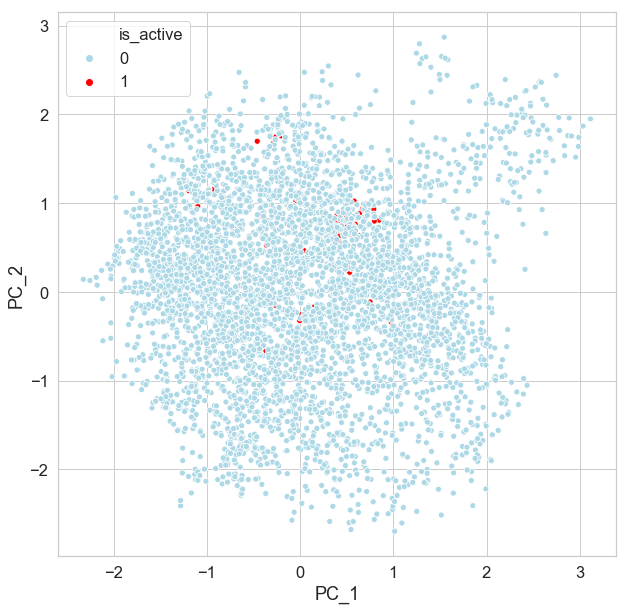

In [10]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="is_active",palette={0:'lightblue',1:'red'})

If we make this plot in two steps, and first plot the decoys then plot the actives, the actives will be much easier to see. 

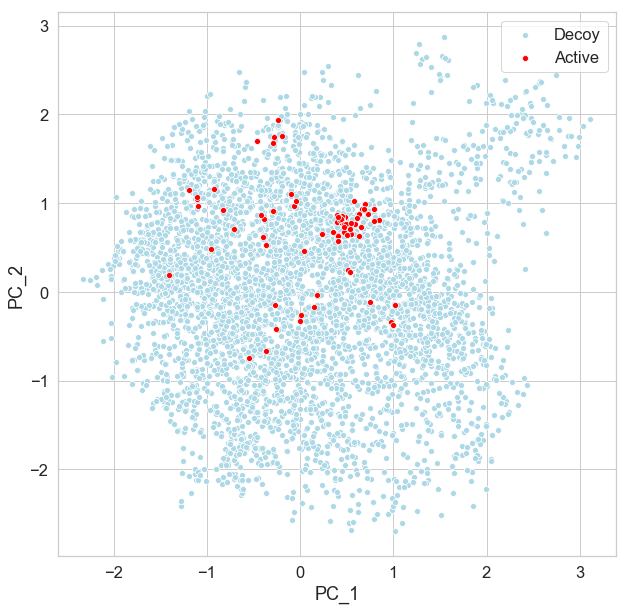

In [11]:
ax = sns.scatterplot(data=crds_df.query("is_active == 0"),x="PC_1",y="PC_2",color='lightblue')
ax = sns.scatterplot(data=crds_df.query("is_active == 1"),x="PC_1",y="PC_2",color='red')
_ = plt.legend(labels=['Decoy', 'Active'])

Let's take a look at the fraction of the overall variance explained by the two principal components that we're plotting.  Only 5%, that's not great. 

In [12]:
var = np.sum(pca.explained_variance_ratio_)
var

0.053458424371226845

Define a function that will evaluate the amount of variance explained for between 5 and 20 principal components.

In [13]:
def evaluate_components(fp_list):
    res = []
    for n_comp in tqdm(range(2,50)):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list) 
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res

Run the function above on our fingerprint list

In [14]:
comp_res = evaluate_components(fp_list)

100%|██████████| 48/48 [00:12<00:00,  3.16it/s]


Put these results into a dataframe

In [15]:
res_df = pd.DataFrame(comp_res,columns=["Components","Variance"])

Look at the first few rows in the dataframe

In [16]:
res_df.head()

,Components,Variance
0,2,0.053458
1,3,0.075413
2,4,0.094854
3,5,0.113174
4,6,0.128108


Make a line plot of the number of components vs the variance explained

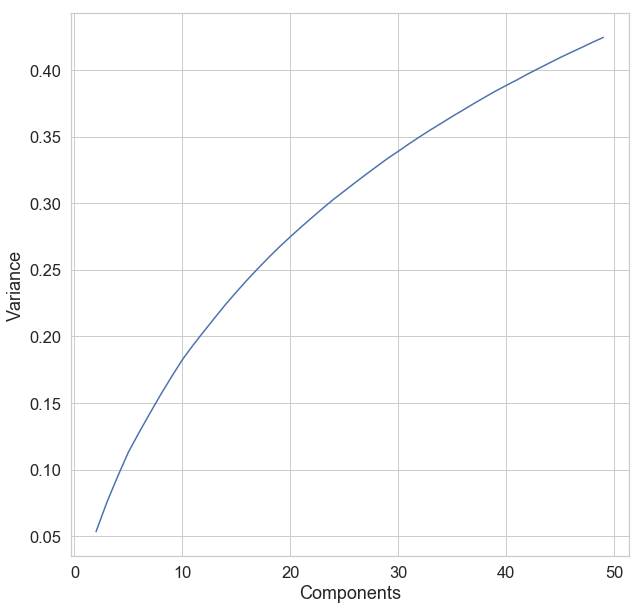

In [17]:
ax = sns.lineplot(data=res_df,x="Components",y="Variance")

Let's take a look at how the plot above varies with the number of bits in a fingerprint. First we'll generate fingerprints with 2048, 1024, and 512 bits.

In [18]:
fp_2048 = fp_list
fp_1024 = fp_list_from_smiles_list(df.SMILES,1024)
fp_512 = fp_list_from_smiles_list(df.SMILES,512)

100%|██████████| 4617/4617 [00:01<00:00, 2591.22it/s]


Now we can evaluate the amount of variance explained as a function of the number of principal components for each of the fingerprint lists defined above.

In [19]:
res_2048 = evaluate_components(fp_2048)
res_1024 = evaluate_components(fp_1024)
res_512 = evaluate_components(fp_512)

100%|██████████| 48/48 [00:04<00:00,  8.47it/s]


Put all of this data into a dataframe to make it easier to deal with.  We will put each dataset into its own dataframe, then combine the three dataframes with "pd.concat". 

In [20]:
df_2048 = pd.DataFrame(res_2048,columns=["Components","Variance"])
df_2048['Bits'] = '2048 Bits'
df_1024 = pd.DataFrame(res_1024,columns=["Components","Variance"])
df_1024['Bits'] = '1024 Bits'
df_512 = pd.DataFrame(res_512,columns=["Components","Variance"])
df_512['Bits'] = '512 Bits'
combo_df = pd.concat([df_2048,df_1024,df_512])

Make a plot showing the impact of fingerprint length on the amount of variance explained.  The bottoe line is that it doesn't make a big difference. 

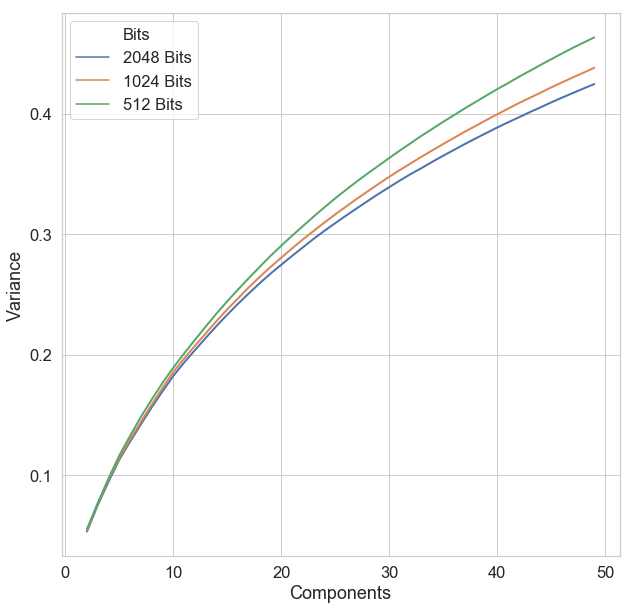

In [21]:
ax = sns.lineplot(x="Components",y="Variance",hue="Bits",data=combo_df,linewidth=2)

We will now run t-distributed stochastic neighbor embedding (TSNE) on this dataset.  According to the [sklearn_docs] PCt-sne works much faster with lower dimensional data.  We will use PCA to reduce our dataset to 50 principal components.

In [22]:
pca = PCA(n_components=50)
crds = pca.fit_transform(fp_list) 

Run the t-sne on the 50 principal component database we created above. On my Mac, this takes about 30 seconds.

In [23]:
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(crds)

CPU times: user 27.8 s, sys: 137 ms, total: 27.9 s
Wall time: 27.7 s


Put the t-sne dataset into a dataframe to simplify plotting.

In [24]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['is_active'] = df['is_active']

Look at the first few lines of the dataframe.

In [25]:
tsne_df.head()

,X,Y,is_active
0,41.287556,-22.176905,1
1,36.604866,7.379683,1
2,-53.929436,62.071556,1
3,-54.394829,62.620041,1
4,-55.063190,62.575531,1


Plot the distribution of the active and decoy molecule with t-sne.  Note that, as above, we plot in two steps to avoid obscuring the red points. 

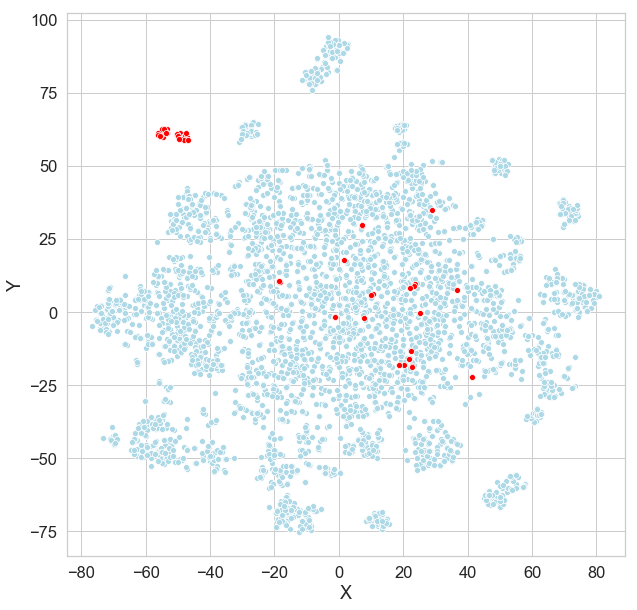

In [26]:
ax = sns.scatterplot(data=tsne_df.query("is_active == 0"),x="X",y="Y",color='lightblue')
ax = sns.scatterplot(data=tsne_df.query("is_active == 1"),x="X",y="Y",color='red')

Create a new dataframe with the data we want to save to disk. 

In [27]:
output_tsne_df = pd.concat([df["ID"],crds_df[["PC_1","PC_2"]],tsne_df[["X","Y"]]],axis=1)
output_tsne_df.head()

,ID,PC_1,PC_2,X,Y
0,168691,-0.061347,0.966096,41.287556,-22.176905
1,86358,-1.403802,0.187907,36.604866,7.379683
2,575087,0.482625,0.844881,-53.929436,62.071556
3,575065,0.410904,0.639878,-54.394829,62.620041
4,575047,0.516694,0.242584,-55.063190,62.575531


Write the dataframe to a csv file.  Note that we set "index=False" to avoid writling line numbers to the csv file.

In [28]:
output_tsne_df.to_csv("../data/dude_erk1_mk01_tnse.csv",index=False)